In [26]:
"""
Imports and global functions.
"""


import numpy as np
from numpy import *
import pandas as pd
from scipy.stats import norm, poisson, chisquare
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def bin_events(events: ndarray, T=10):
    """
    Given an array of timestamps for detector events, calculate the number
    of events that occured in each T-second interval.

    Parameters
    ----------
    events: float ndarray
        Timestamps for events.
    T: float
        Width of each time bin.

    Returns
    -------
    counts: float ndarray
        Number of events in each interval.
    """

    # Useful constants.
    max_t = max(events)
    num_intervals = int(ceil(max_t / T))
    event_counts = zeros(num_intervals, dtype=int)
    
    # Add each event to corresponding bin.
    for t in events:
        I = int(t // T)
        event_counts[I] += 1 
    return event_counts


def integer_histogram(a: ndarray, num_bins=-1, width=-1):
    """
    Special histogram function for positive integer data (e.g. the number
    of detector events in a fixed time interval). Special care needed to
    avoid bins like [10.2, 10.7), which will NEVER have any data. Best bin
    edges are half-integer.

    Parameters
    ----------
    a: int ndarray
        Input data, something analogous to "number of detector events".
    num_bins: int
        Number of histogram bins.
    width: int
        Width of each bin, overrides centers.

    Return
    ------
    hist: int ndarray
        Value of histogram.
    centers: float ndarray
        Centers of each bin.
    """

    assert a.dtype == int
    assert num_bins != -1 or width != -1
    if num_bins != -1:
        width = max(a) // num_bins
    else:
        pass
    print(f"Using bin width: {width}.")
    edges = arange(min(a) - 0.5, max(a) + 1.5, width)
    centers = (edges[:-1] + edges[1:]) / 2
    hist, _ = np.histogram(a, bins=edges)
    return (hist, centers)


def running_average(x: ndarray) -> ndarray:
    return cumsum(x) / arange(1, len(x) + 1)


def block_stats(x: ndarray, b: int) -> tuple[ndarray, ndarray]:
    num_blocks = len(x) // b
    x_blocked = x[:num_blocks * b].reshape(num_blocks, b)
    block_avgs = x_blocked.mean(axis=1)
    block_stds = x_blocked.std(axis=1, ddof=1)
    return block_avgs, block_stds

In [15]:
"""
Import data.
"""


# Read text file using Pandas (I pre-stripped junk from top of file).
with open('FileC017.txt', 'r') as file:
    lines = file.readlines()
header = lines[0].strip().split()
data_lines = [line.strip().split('\t') for line in lines[1:]]
df = pd.DataFrame(data_lines, columns=header)

# Extract event times and convert ms->s.
events = df["TimeStamp[ms]"].astype(float).to_numpy() / 1000

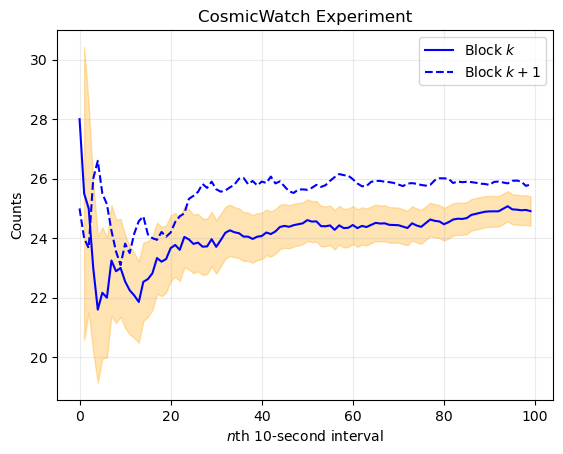

In [16]:
"""
XS1: In-Class Exercise X1.3 "Poisson statistics"

Measuring the mean, part 2: plot the running average.
Measuring the mean, part 3: plot the error bars.
"""


# Extract 100 10-s bins and take statistics.
counts = bin_events(events, T=10) # T is the bin time.
N = 100 # Number of bins.
k = 0  # Which seris of N bins.
x, y_1 = arange(N), running_average(counts[k * N:(k + 1) * N])
x, y_2 = arange(N), running_average(counts[(k + 1) * N:(k + 2) * N])
sigma = std(counts[k * N:(k + 1) * N], ddof=1)

# Plot first 100, next 100, and error bar.
plt.plot(x, y_1,
         color='blue', label="Block $k$")
plt.plot(x, y_2,
         color='blue', linestyle="--", label="Block $k + 1$")
plt.fill_between(x[1:], y_1[1:] - sigma / sqrt(x[1:]), y_1[1:] + sigma / sqrt(x[1:]),
                 color='orange', alpha=0.3)
plt.grid(alpha=0.25)

# Cosmetics.
plt.title("CosmicWatch Experiment")
plt.xlabel('$n$th 10-second interval')
plt.ylabel('Counts')
plt.legend()
plt.show()

Average for first 100 10-s bins: 24.91.
Average for first 100 10-s bins: 25.81.
Error of first 100 10-s bins estimate: 0.4927955709495316.
Probability of a larger error 6.78%.


Text(0, 0.5, 'Number of Intervals')

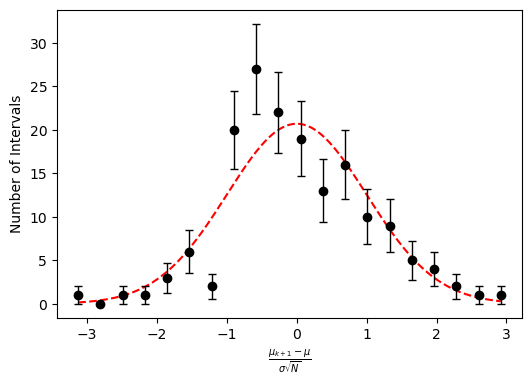

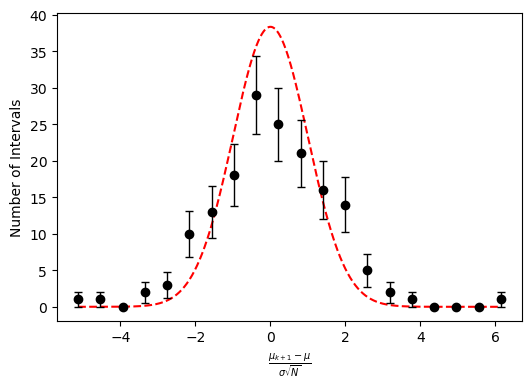

In [17]:
"""
XS1: In-Class Exercise X1.3 "Poisson statistics"

Measuring the mean, part 4: reliability of estimated error bar.
"""

# Compare the first and second block of 100 intervals.
N = 100
avgs, stds = block_stats(counts, N)
mu_0, mu_1 = avgs[0:2]
sigma_0 = stds[0] / np.sqrt(N)
p_larger = 200 * (1 - norm.cdf((mu_1 - mu_0) / sigma_0))
print(f"Average for first 100 10-s bins: {mu_0}.")
print(f"Average for first 100 10-s bins: {mu_1}.")
print(f"Error of first 100 10-s bins estimate: {sigma_0}.")
print(f"Probability of a larger error {p_larger:.2f}%.")

# Compare block average with average of ALL blocks.
errs = (avgs - average(avgs)) / std(avgs)
pops, edges = histogram(errs, bins=20)
centers = (edges[:-1] + edges[1:]) / 2
width = edges[1] - edges[0]
scaler = width * sum(pops)
fit_grid = linspace(min(centers), max(centers), 1000)

# Plot the above.
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(centers, pops, yerr=sqrt(pops),
            fmt='o', c="k", capsize=3, elinewidth=1)
ax.plot(fit_grid, scaler * norm.pdf(fit_grid),
        zorder=-10, linestyle="--", color="r")
ax.set_xlabel(r"$\frac{\mu_{k+1} - \mu}{\sigma\sqrt{N}}$")
ax.set_ylabel("Number of Intervals")

# Compare (k+1)th average with (k)th average and error estimate.
errs = (avgs[1:] - avgs[:-1]) / (stds[:-1] / sqrt(N))
pops, edges = histogram(errs, bins=20)
centers = (edges[:-1] + edges[1:]) / 2
width = edges[1] - edges[0]
scaler = width * sum(pops)
fit_grid = linspace(min(centers), max(centers), 1000)

# Plot the above.
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(centers, pops, yerr=sqrt(pops),
            fmt='o', c="k", capsize=3, elinewidth=1)
ax.plot(fit_grid, scaler * norm.pdf(fit_grid),
        zorder=-10, linestyle="--", color="r")
ax.set_xlabel(r"$\frac{\mu_{k+1} - \mu}{\sigma\sqrt{N}}$")
ax.set_ylabel("Number of Intervals")

Using bin width: 1.


Text(0, 0.5, 'Frequency')

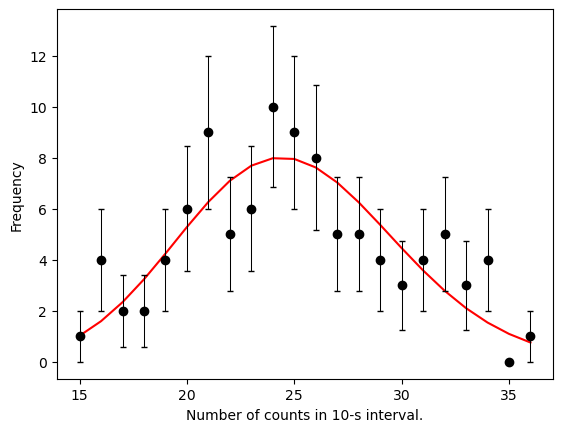

In [ ]:
T = 10
N = 100
counts = bin_events(events, T=10) # T is the bin time.
freqs, centers = integer_histogram(counts[:N], width=1)
width = centers[1] - centers[0]
grid = np.arange(np.floor(centers)[0], np.ceil(centers)[-1] + 1)

plt.errorbar(centers, freqs, yerr=sqrt(freqs), label="Exp. Data",
             fmt='o', c="k", capsize=2, elinewidth=0.75, zorder=10)
plt.plot(grid, N * width * poisson.pmf(grid, average(counts[:N])), c="r", label="Poisson Fit")
plt.xlabel(f"Number of counts in {T}-s interval.")
plt.ylabel("Frequency")

In [35]:
expected = N * width * poisson.pmf(centers[freqs > 0], average(counts[:N]))
sum((freqs[freqs > 0] - expected) ** 2 / freqs[freqs > 0])

10.271096968969962